# **GestoAI: An Italian Gesture Recognition Model using YOLOv5 for Real-Time Object Detection with Computer Vision**


**About the Project**

GestoAI is an object detection model designed to recognize and interpret Italian hand gestures using the YOLOv5 architecture. This project aims to capture the richness of Italian nonverbal communication by identifying and classifying distinct hand gestures in real-time. By leveraging advanced computer vision, GestoAI has potential applications in cross-cultural communication, interactive education, and immersive experiences, bringing the expressive nature of Italian gestures into digital spaces.

**Project Owner: Manuel Contreras**

**1 - Settings**

The **YOLO (You Only Look Once) models** by **Ultralytics** are a family of real-time object detection models known for their speed and accuracy.

Some notable features include:

* Ease of Use: YOLOv5 provides a Pythonic interface with compatibility for PyTorch, making it very accessible for developers.
* Flexible Model Sizes: The different sizes are designed to fit various needs—smaller models like YOLOv5s are faster and suitable for real-time applications, while larger ones like YOLOv5x provide higher accuracy.
* Pre-trained Weights: Ultralytics offers pre-trained weights on popular datasets like COCO, enabling transfer learning and rapid deployment.

In [1]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 17022, done.
remote: Total 17022 (delta 0), reused 0 (delta 0), pack-reused 17022 (from 1)
Receiving objects: 100% (17022/17022), 15.62 MiB | 16.37 MiB/s, done.
Resolving deltas: 100% (11695/11695), done.
/content/yolov5


In [ ]:
%pwd

In [ ]:
# dependencies
!pip install -qr requirements.txt
import torch

from IPython.display import Image, clear_output  # image displaying
# from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

In [ ]:
%cd /content


**2- Import Dataset**

The dataset comprises images initially captured using a Jupyter-based algorithm and subsequently labeled through the Roboflow platform. It includes 240 images representing 17 distinct Italian hand gestures, specifically: Awesome, Be Silent, Calm Down, Delicious, Cornutto, Hello, I Cannot Stand You, I Did Not Hear Well, I Don’t Know, I Forgot, I’ve Had Enough, I Hope So, Let’s Go, Oh Please, Pay Attention to That, and This Person Is Such a Talker.

In [ ]:
%cd /content
!curl -L "https://github.com/Manuel17410/Pics/raw/refs/heads/main/Italian%20Gestures.v1i.yolov5pytorch.zip" > SignData.zip; unzip SignData.zip; rm SignData.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 5287k  100 5287k    0     0   9.9M      0 --:--:-- --:--:-- --:--:--  9.9M
Archive:  SignData.zip
replace data.yaml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**3- YAML file and its addaptation**

In [ ]:
# YAML file  to be loaded to the notebook with the data
%cat data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 17
names: ['Awesome', 'Be silent', 'Calm down', 'Cornutto', 'Delicious', 'Hello', 'I cannot stand you', 'I did not hear well', 'I do not care', 'I do not know', 'I forgot', 'I had enough', 'I hope so', 'Lets go', 'Oh please', 'Pay attention to that', 'This person is such a talker']

roboflow:
  workspace: manuel-contreras
  project: italian-gestures
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/manuel-contreras/italian-gestures/dataset/1

In [ ]:
# Rewrite data.yaml without the val entry
data_yaml = """
train: ../train/images
test: ../test/images

nc: 17
names: ['Awesome', 'Be silent', 'Calm down', 'Cornutto', 'Delicious', 'Hello', 'I cannot stand you', 'I did not hear well', 'I do not care', 'I do not know', 'I forgot', 'I had enough', 'I hope so', 'Lets go', 'Oh please', 'Pay attention to that', 'This person is such a talker']

roboflow:
  workspace: manuel-contreras
  project: italian-gestures
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/manuel-contreras/italian-gestures/dataset/1
"""

# Save the updated content to data.yaml
with open("/content/data.yaml", "w") as file:
    file.write(data_yaml)

print("Updated data.yaml without the val entry.")


Updated data.yaml without the val entry.


In [ ]:
# final YAML file
%cat data.yaml


train: ../train/images
test: ../test/images

nc: 17
names: ['Awesome', 'Be silent', 'Calm down', 'Cornutto', 'Delicious', 'Hello', 'I cannot stand you', 'I did not hear well', 'I do not care', 'I do not know', 'I forgot', 'I had enough', 'I hope so', 'Lets go', 'Oh please', 'Pay attention to that', 'This person is such a talker']

roboflow:
  workspace: manuel-contreras
  project: italian-gestures
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/manuel-contreras/italian-gestures/dataset/1


In [ ]:
 #number of classes
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
num_classes

'17'

**4- Model Configuration**

In [ ]:
#model to be used
%cat /content/yolov5/models/yolov5s.yaml

# Ultralytics YOLOv5 🚀, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4],

In [ ]:
#customize iPython writefile to write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
# Verification to check if the train and test directories have been set up correctly
!ls /content/train/images
!ls /content/test/images

Awesome-0e09693f-96a9-11ef-83af-b296dfd7473b_jpg.rf.752e572ad1649c26cb1eaf0555c23588.jpg
Awesome-0f3da047-96a9-11ef-a8e8-b296dfd7473b_jpg.rf.f8e063d32d338cbc2d80648ca3d99393.jpg
Awesome-107222ed-96a9-11ef-b94f-b296dfd7473b_jpg.rf.ce74e39b68c5fd4a7ca1acd3f5f69b79.jpg
Awesome-11a648a6-96a9-11ef-ad61-b296dfd7473b_jpg.rf.685e19529ea6b1673d36684d9985b073.jpg
Awesome-140f9127-96a9-11ef-b5b0-b296dfd7473b_jpg.rf.9b0b94d25931ead0cdf8ca84cabe578e.jpg
Awesome-154505a8-96a9-11ef-94b7-b296dfd7473b_jpg.rf.fc97ae692b694574731382b8e0365a80.jpg
Awesome-1678a27f-96a9-11ef-9236-b296dfd7473b_jpg.rf.c6a4758ce062f34790a7193b6502a282.jpg
Awesome-66b54fdb-96a7-11ef-932f-b296dfd7473b_jpg.rf.f5158fdd75e7c0806242a3b8e2f0330b.jpg
Awesome-691e6bb5-96a7-11ef-8464-b296dfd7473b_jpg.rf.8e2908edf51f50e32ec18b6d3649e386.jpg
Awesome-6a51e959-96a7-11ef-a8d6-b296dfd7473b_jpg.rf.b4ff5c559081fe3e21b74d0b48e63727.jpg
Awesome-6b858063-96a7-11ef-9f91-b296dfd7473b_jpg.rf.14bfe58ccfb6816cf52da37481e4ef39.jpg
Be-silent-8c7ea5a6-96

In [ ]:
# data.yaml file with the necessary content
yaml_content = """
train: /content/train/images
val: /content/test/images

nc: 17
names: ['Awesome', 'Be silent', 'Calm down', 'Cornutto', 'Delicious',
        'Hello', 'I cannot stand you', 'I did not hear well',
        'I do not care', 'I do not know', 'I forgot', 'I had enough',
        'I hope so', 'Lets go', 'Oh please',
        'Pay attention to that', 'This person is such a talker']
"""

# content to data.yaml
with open('/content/data.yaml', 'w') as f:
    f.write(yaml_content)


In [ ]:
# Check the data.yaml file
!cat /content/data.yaml



train: /content/train/images
val: /content/test/images

nc: 17
names: ['Awesome', 'Be silent', 'Calm down', 'Cornutto', 'Delicious',
        'Hello', 'I cannot stand you', 'I did not hear well',
        'I do not care', 'I do not know', 'I forgot', 'I had enough',
        'I hope so', 'Lets go', 'Oh please',
        'Pay attention to that', 'This person is such a talker']


**Model Training**

1- with 100 epochs

2- with 500 epochs

In [ ]:
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data '/content/data.yaml' --cfg ./models/custom_yolov5s.yaml --weights 'yolov5s.pt' --name yolov5s_results --cache


/content/yolov5
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-02 09:50:09.853014: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-02 09:50:09.874550: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-02 09:50:09.880385: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: 

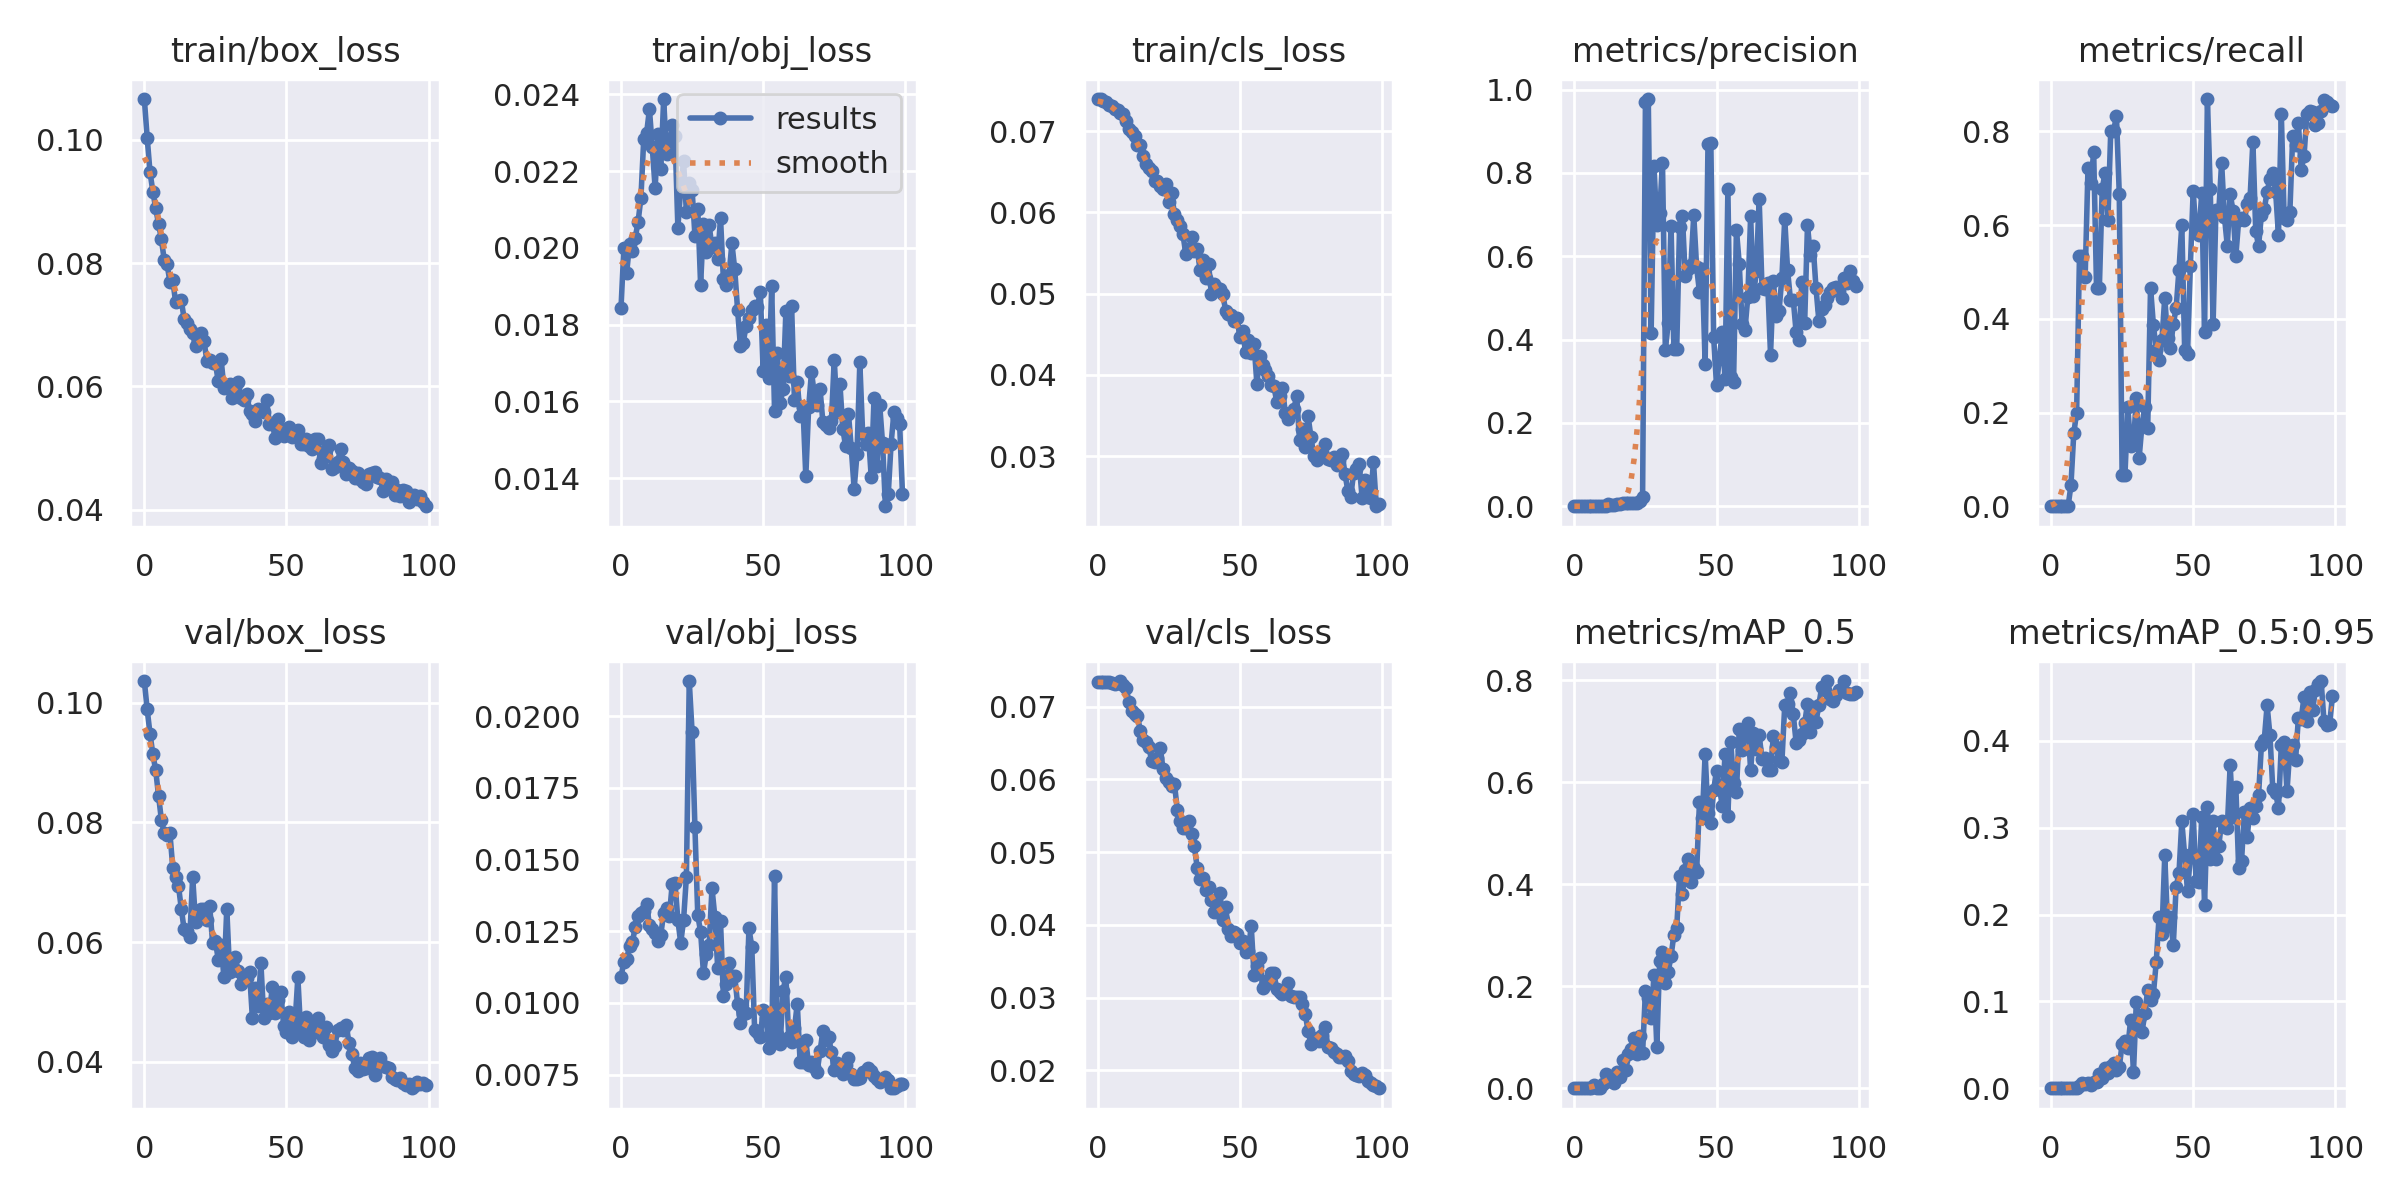

In [ ]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results2/results.png', width=1000)  # view results.png

GROUND TRUTH TRAINING DATA:


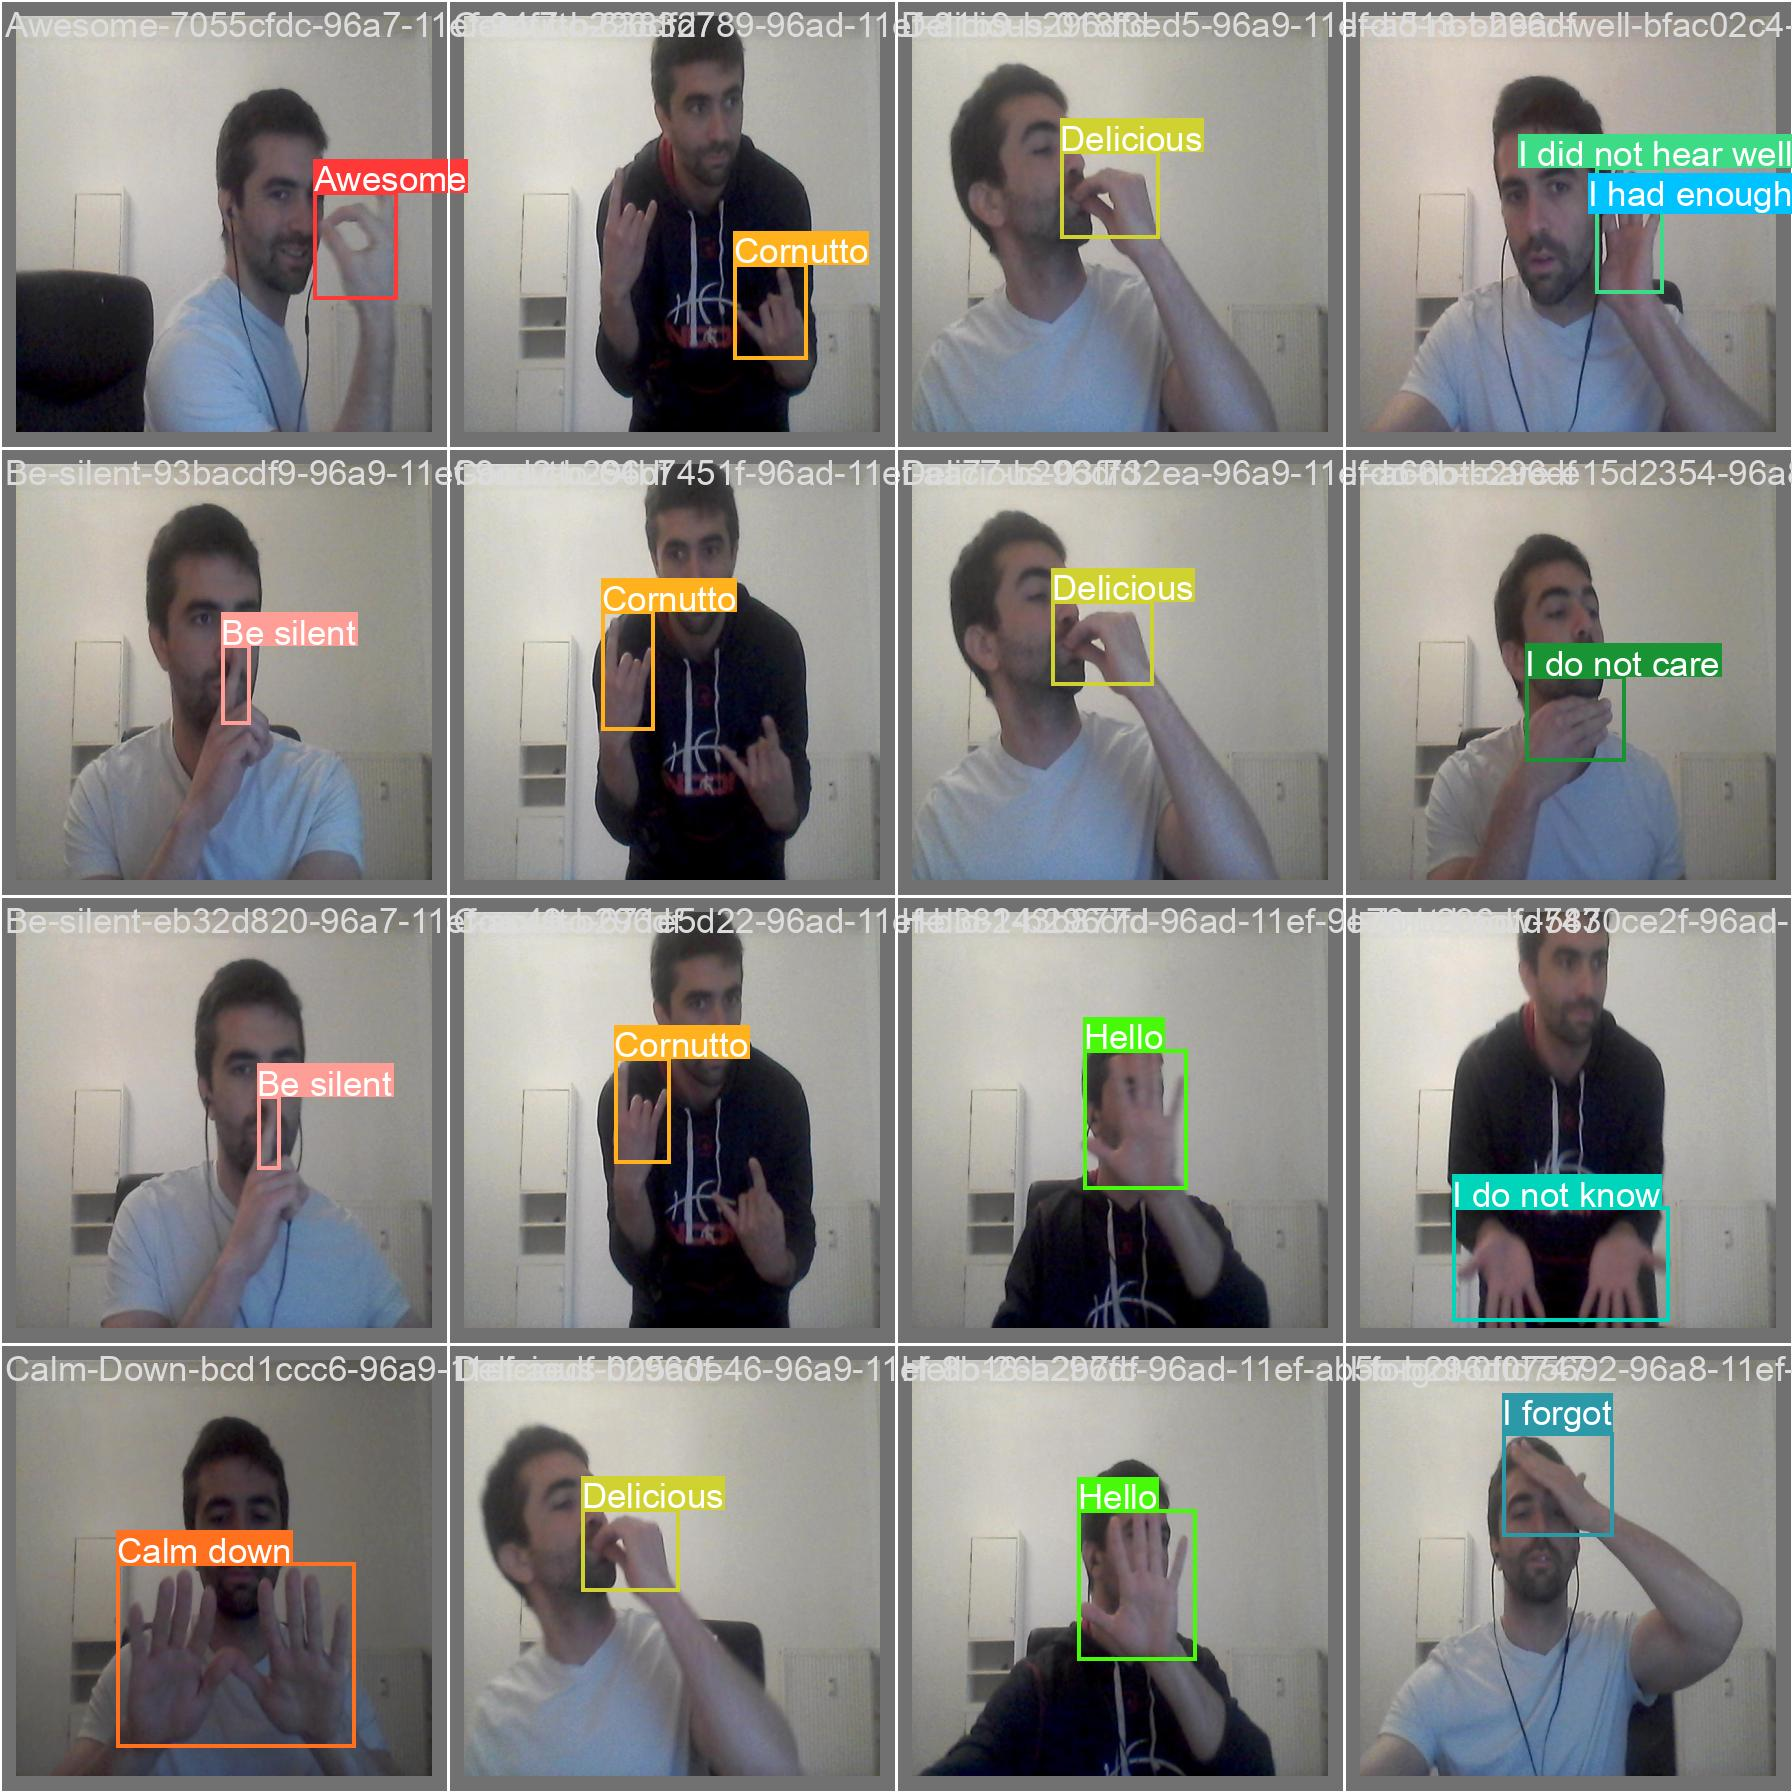

In [ ]:
# display ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results2/val_batch0_labels.jpg', width=900)

As we can see from the pictures above, the model is predicting really well. The only picture that it is getting wrong is the fourth, which should only be labeled as "I did not hear".

In [ ]:
# train yolov5s on custom data for 500 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 500 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights 'yolov5s.pt' --name yolov5s_results  --cache


Streaming output truncated to the last 5000 lines.
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:00<00:00,  4.78it/s]
                   all         24         24      0.731      0.933      0.874      0.522

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
  0% 0/11 [00:00<?, ?it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
    299/499      1.93G    0.03016    0.01052   0.008091         27        416:   9% 1/11 [00:00<00:01,  8.21it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
    299/499      1.93G    0.03044    0.01139   0.007372         33        416:  18% 2/11 [00:00<00:01,  7.22it/s]/content/yolov5/train.py:

This model achieves an accuracy of **0.6**, which is good given the relatively small size of the dataset and the numerous categories it encompasses.

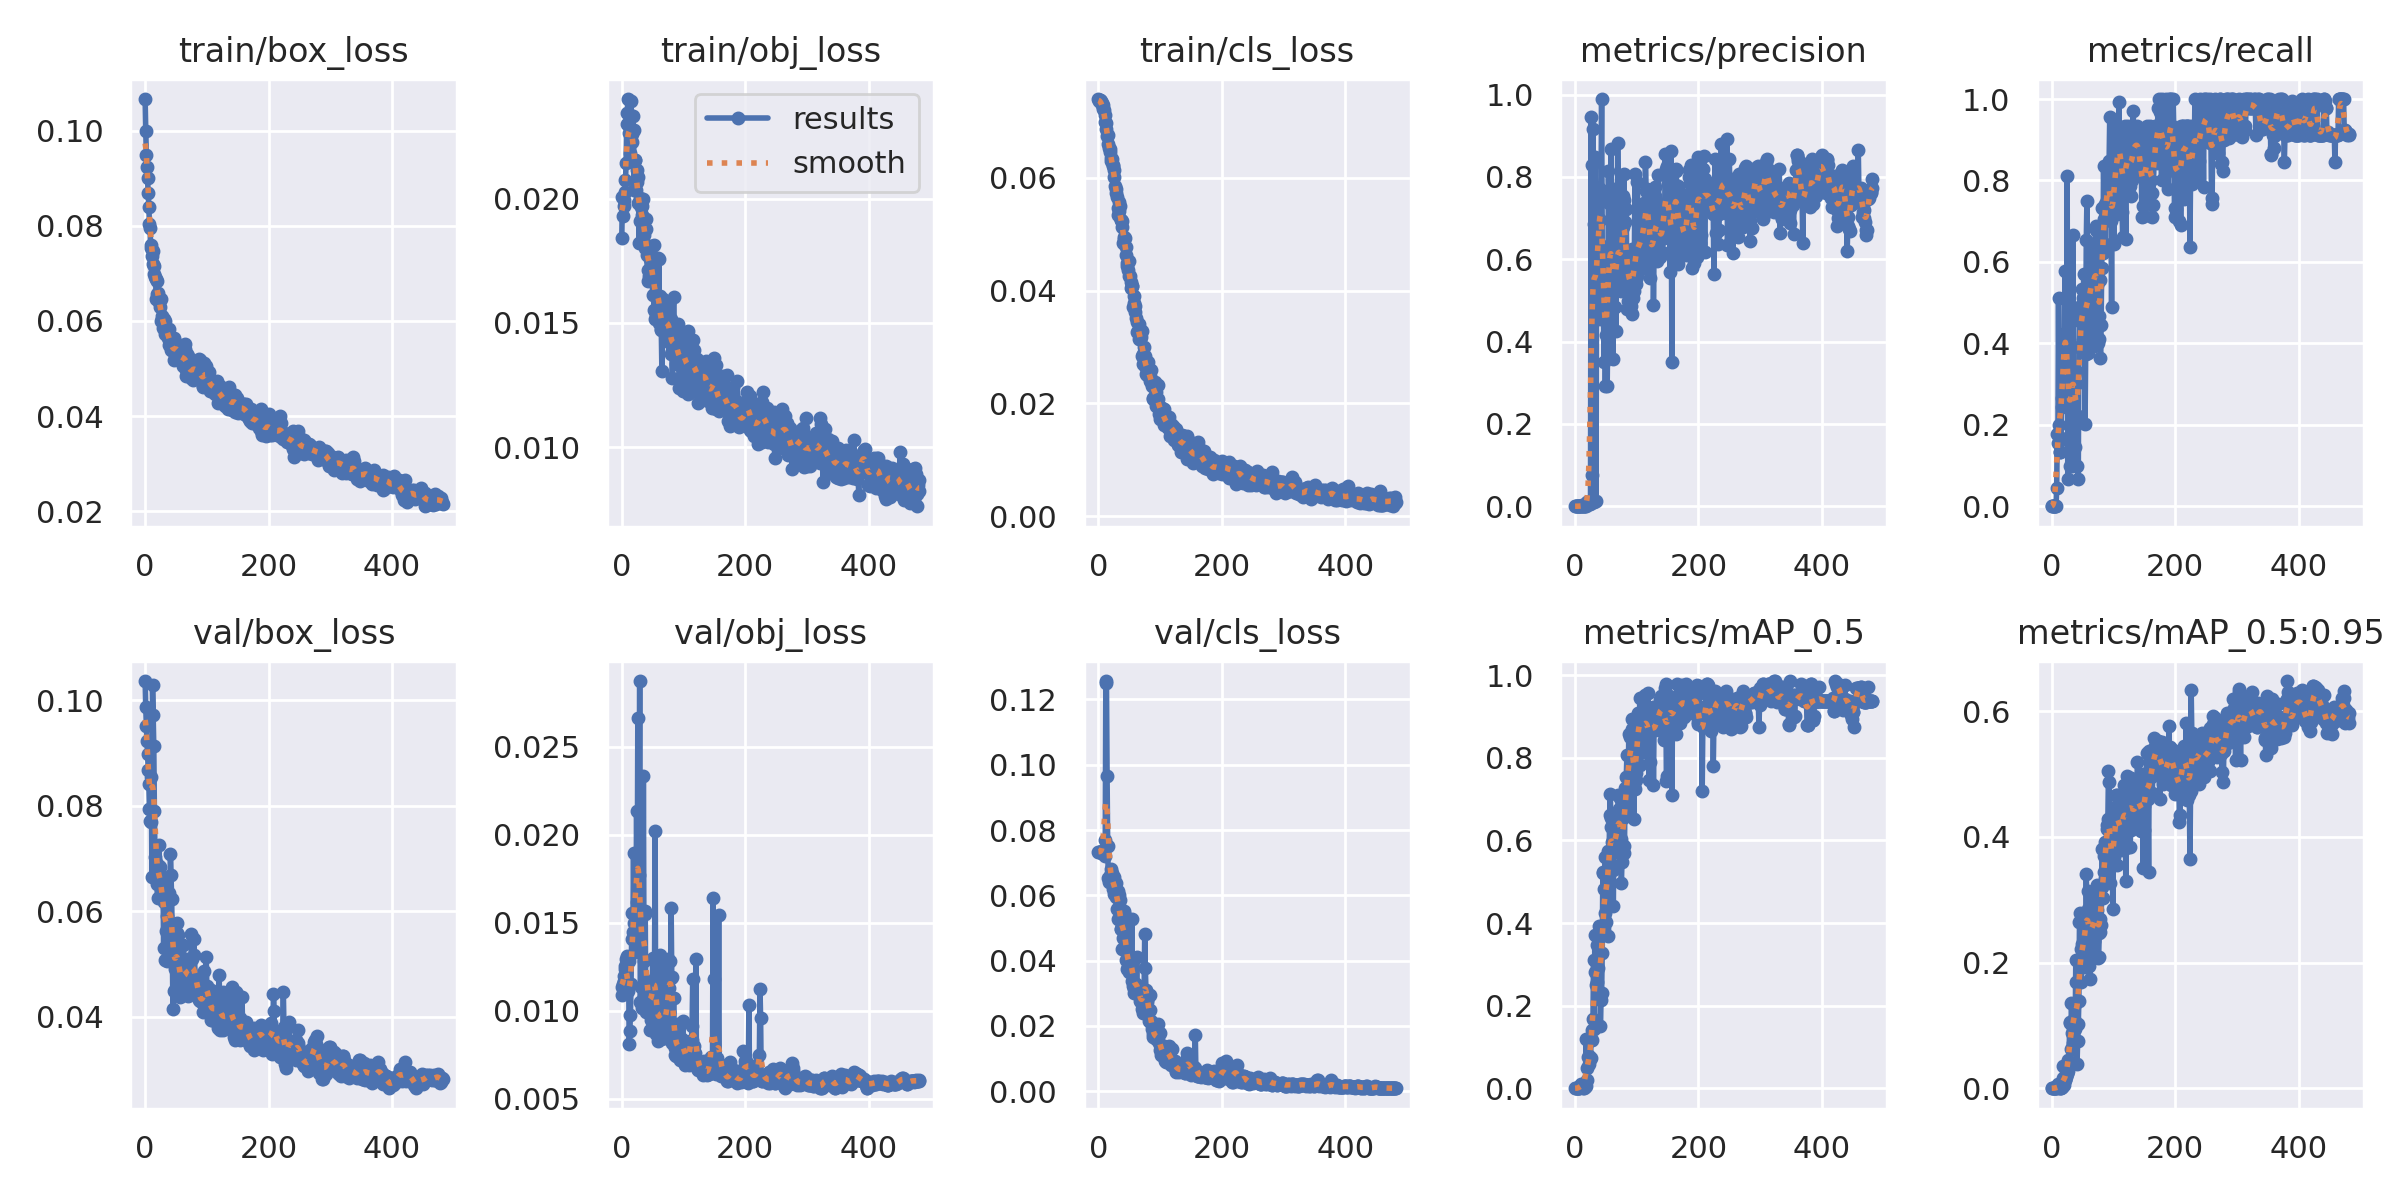

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason...
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

GROUND TRUTH TRAINING DATA:


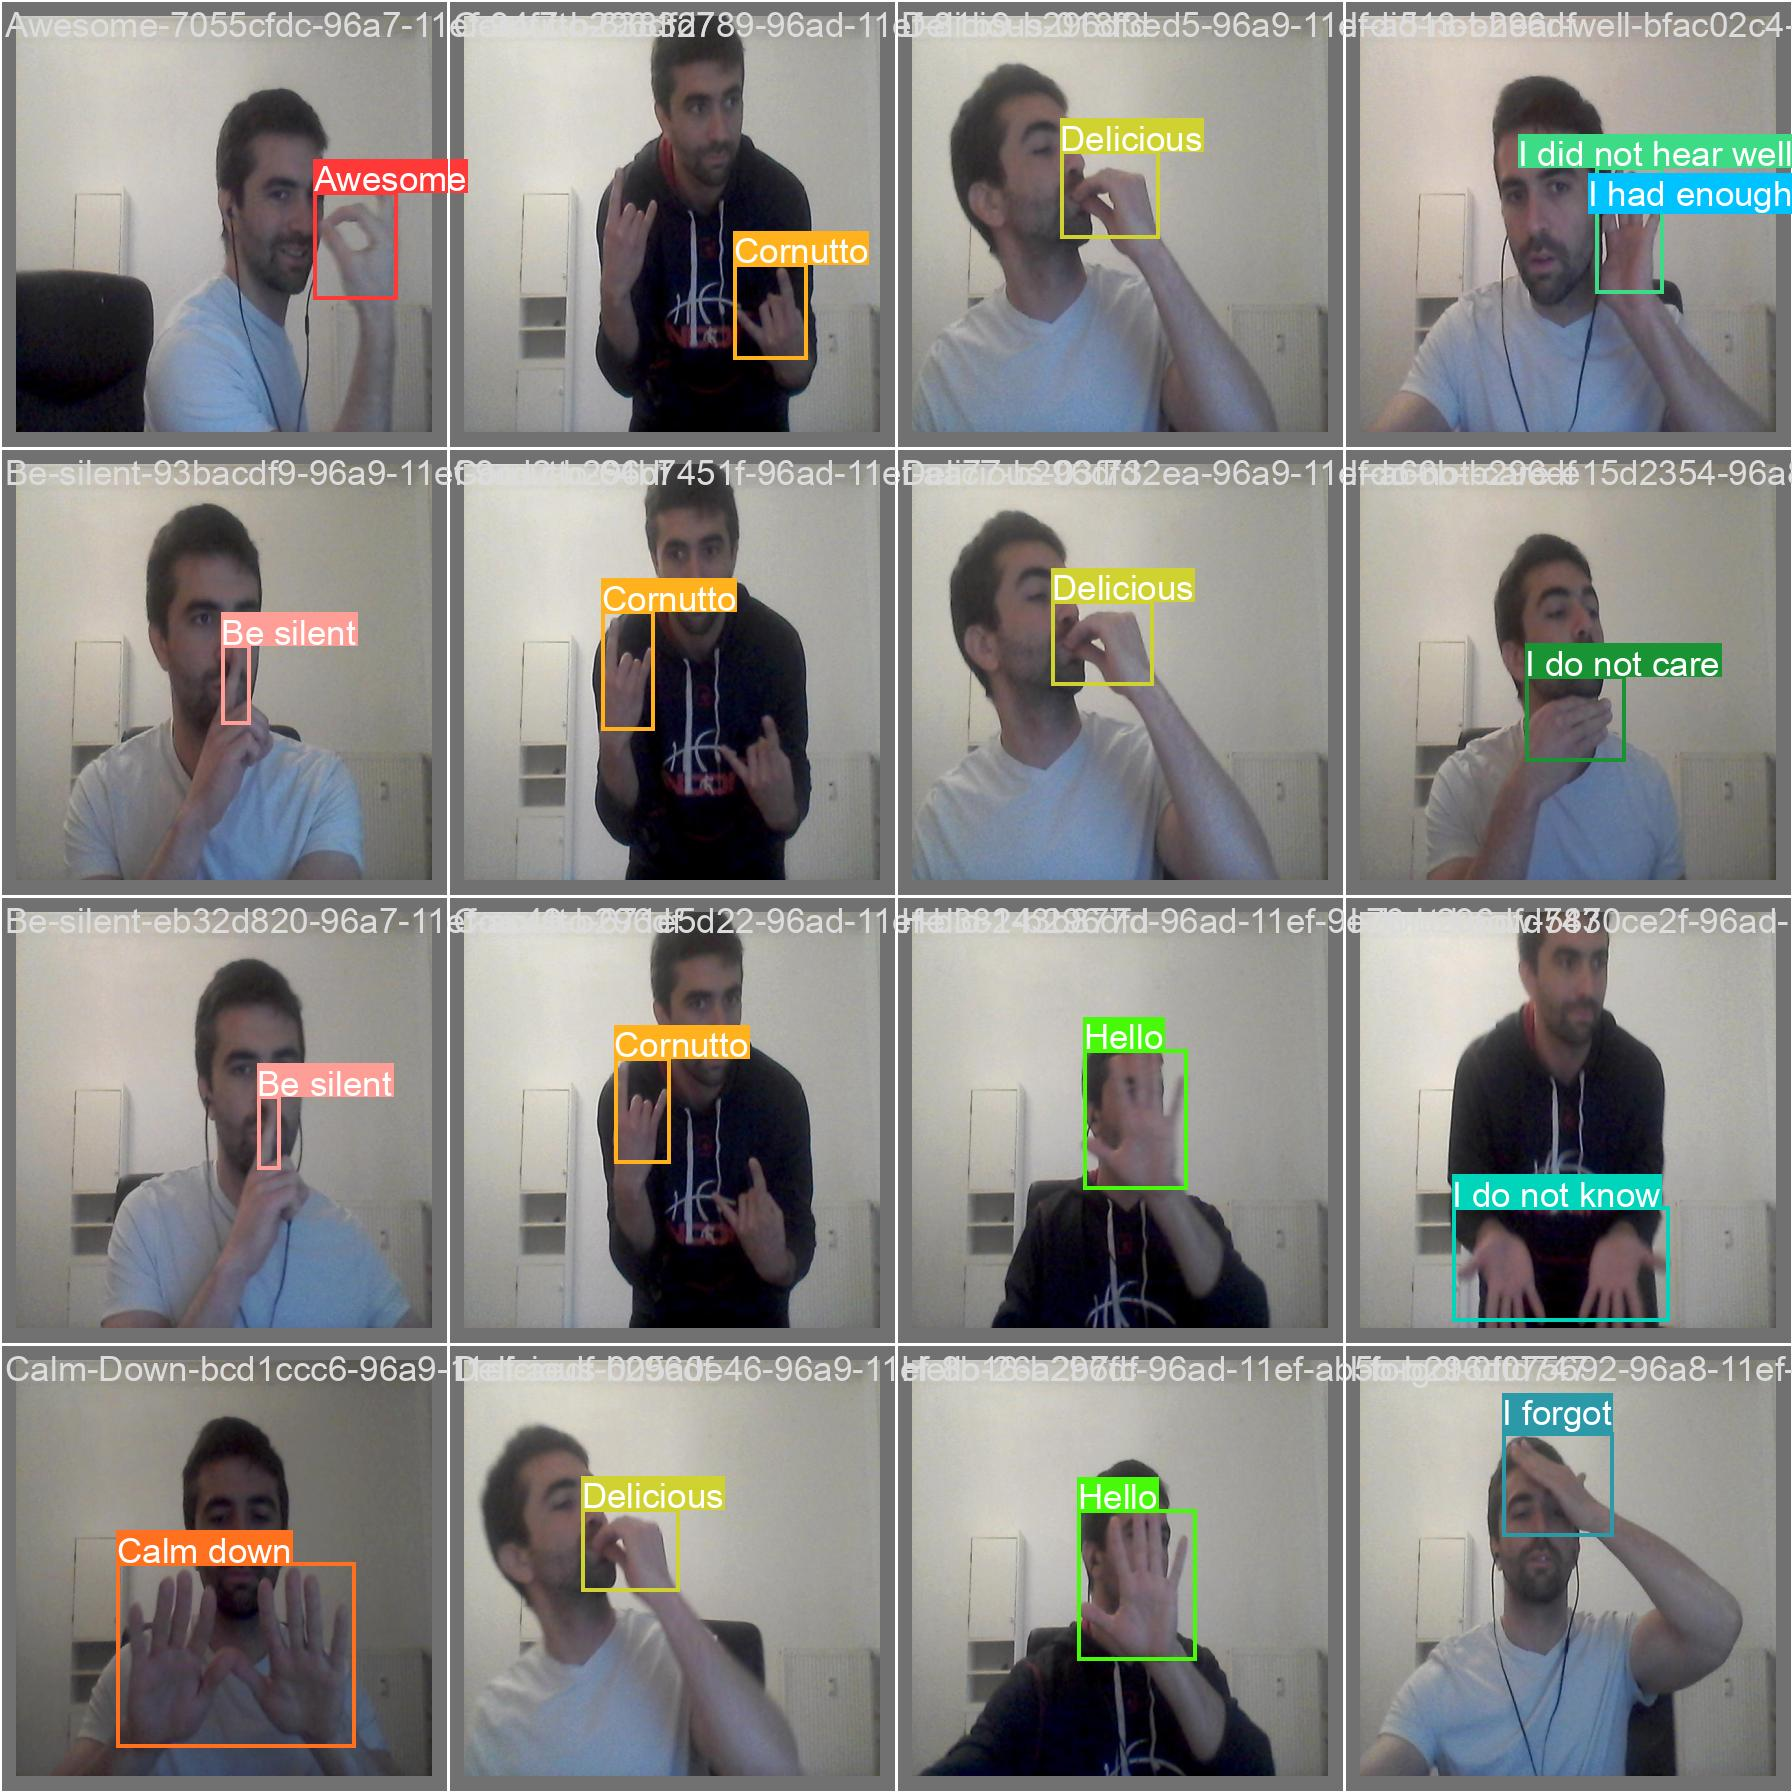

In [ ]:
# display ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

In [ ]:
# trained weights are saved by default
%ls runs/

train/


In [ ]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [ ]:

%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.5 --source ../test/images

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=../test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-378-g2f74455a Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7289670 parameters, 0 gradients
image 1/24 /content/test/images/Awesome-7055cfdc-96a7-11ef-94f7-b296dfd7473b_jpg.rf.176337ec062832a74156b3299e511c62.jpg: 416x416 (no detections), 7.8ms
WARNING ⚠️ NMS time limit 0.550s exceeded
image 2/24 /content/test/images/Be-silent-93bacdf9-96a9-11ef-9cd2-b296dfd7473b_jpg.rf.8db8440d1b2749c